In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

true_path = '/content/drive/MyDrive/True.csv'
fake_path = '/content/drive/MyDrive/Fake.csv'

true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

# Add Labels to both df
true_df['true'] = 1
fake_df['true'] = 0

# Concat
df = pd.concat([true_df, fake_df])
df.head(5)


Mounted at /content/drive


,title,text,subject,date,true
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [2]:
print(df.shape)
df.isna().sum()

(44898, 5)


title      0
text       0
subject    0
date       0
true       0
dtype: int64

,title,true
0,NEW ACCUSATION AGAINST BERNIE SANDERS Exposes ...,0
1,Wife Of Pastor Freed In Iran Just Demolished ...,0
2,McConnell SUPPRESSED Info That Russia Worked ...,0
3,Michael Flynn’s Resignation Letter Omits One ...,0
4,Trump picks NJ Governor Christie to head trans...,1
...,...,...
44893,Lebanese army says has not uncovered any assas...,1
44894,‘Half my family’ is here illegally!…State Sena...,0
44895,Illinois Republicans push for state takeover o...,1
44896,#BoycottGrammys… #TurnOffTheGrammys…Grammys Pr...,0


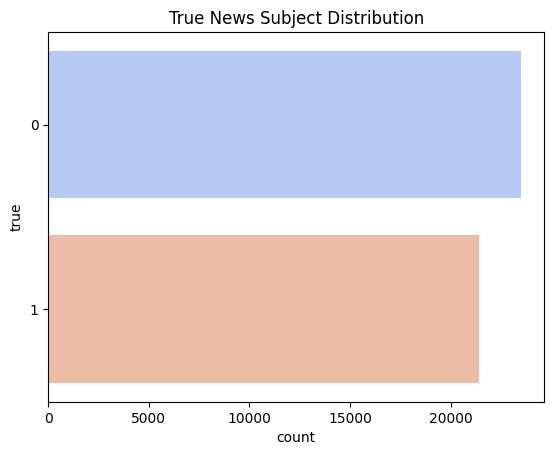

In [3]:
from sklearn.utils import shuffle

# Shuffle
df = shuffle(df).reset_index(drop=True)
# Purify
df = df.iloc[:,[0, -1]]
display(df)
sns.countplot(y="true", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   44898 non-null  object
 1   true    44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


In [5]:
df.drop_duplicates(subset=['title'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38729 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   38729 non-null  object
 1   true    38729 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 907.7+ KB


In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
list_of_words = []

for title in df['title'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    list_of_words.append(word)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
unique_words = list(set(word for sentence in list_of_words for word in sentence.split()))
voc_size = len(unique_words)

In [8]:
titles = [text for text in list_of_words]

max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))
print('Median length of the titles:', np.median(titles_len))

Number of titles: 38729
Max length of the titles: 35
Mean length of the titles: 9.127733739574996
Median length of the titles: 9.0


In [9]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
tokenizer = Tokenizer(num_words = voc_size)
tokenizer.fit_on_texts(df['title'])

sequences = tokenizer.texts_to_sequences(df['title'])
padded_df = pad_sequences(sequences,maxlen = max_len, padding = 'pre', truncating = 'post')


# **LSTM**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
## Creating model Using LSTM

embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_len))
model.add(Dropout(0.3))
model.add(Conv1D(32,5,activation='relu'))
model.add(MaxPool1D())
model.add(Conv1D(32,5,activation='relu'))
model.add(MaxPool1D())
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])



In [11]:
from sklearn.model_selection import train_test_split
z =np.array(padded_df)
y =np.array(df['true'])
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)


In [12]:
# upsampling and shuffle
import numpy as np
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train, y_train = ros.fit_resample(x_train, y_train)
x_val, y_val = ros.fit_resample(x_val, y_val)
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_val, y_val = shuffle(x_val, y_val, random_state=42)

Epoch 1/3
458/458 [==============================] - 41s 54ms/step - loss: 0.2101 - accuracy: 0.9095 - val_loss: 0.1490 - val_accuracy: 0.9443
Epoch 2/3
458/458 [==============================] - 6s 13ms/step - loss: 0.0749 - accuracy: 0.9732 - val_loss: 0.1476 - val_accuracy: 0.9516
Epoch 3/3
458/458 [==============================] - 7s 14ms/step - loss: 0.0399 - accuracy: 0.9859 - val_loss: 0.1536 - val_accuracy: 0.9478


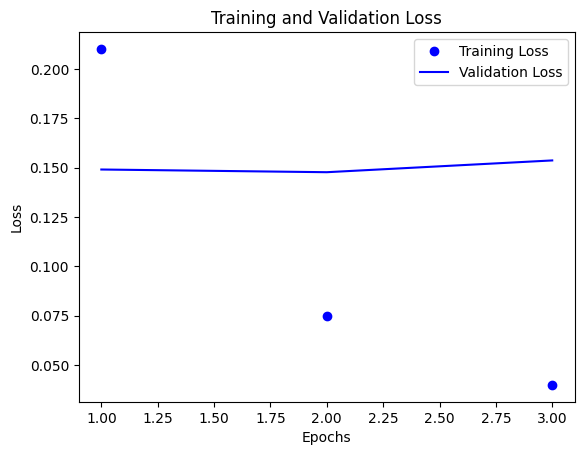

In [13]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 3)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

243/243 [==============================] - 1s 3ms/step
CNN-BiLSTM Model Accuracy :  0.9478440485411825
Precision :  0.9504152418172936
Recall :  0.9508797653958945
F1 :  0.9506474468604936
G-mean: 0.9476566423356031
Training time:  86.24683427810669
Inference time:  1.9592602252960205
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3654
           1       0.95      0.95      0.95      4092

    accuracy                           0.95      7746
   macro avg       0.95      0.95      0.95      7746
weighted avg       0.95      0.95      0.95      7746



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


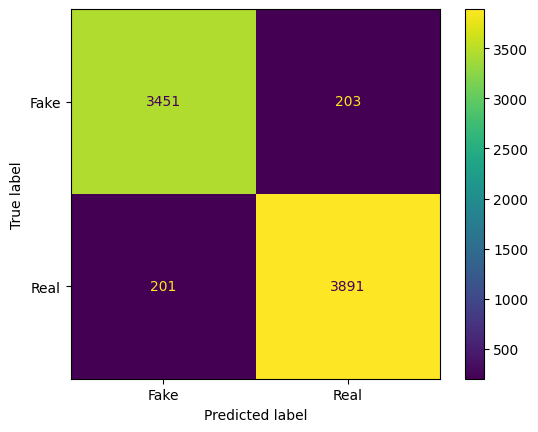

In [14]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("CNN-BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()